In [13]:
from typing import Dict
from rdkit import Chem
from rdkit.Chem import AllChem, rdDistGeom, rdMolDescriptors, Descriptors3D

def build_linear_polymer_from_dummy_monomer(
    monomer_smiles: str,
    repeat_count: int
) -> Chem.Mol:
    """
    Accepts either
      • [*:1]…[*:2]   (map-labelled dummies)
      • *…*           (unlabelled dummies – first two are used)
    and returns an N-mer with the dummies converted to sp³ carbons.
    """
    monomer = Chem.MolFromSmiles(monomer_smiles)
    if monomer is None:
        raise ValueError("SMILES failed to parse")

    dummy_atoms = [a for a in monomer.GetAtoms() if a.GetSymbol() == '*']
    if len(dummy_atoms) < 2:
        raise ValueError("Need at least two '*' atoms as attachment points")

    # --- pick the two anchor atoms -----------------------------------------
    labelled = {a.GetAtomMapNum(): a for a in dummy_atoms if a.GetAtomMapNum()}
    if 1 in labelled and 2 in labelled:
        a1, a2 = labelled[1].GetIdx(), labelled[2].GetIdx()
    else:                                 # fall back: first two dummies
        a1, a2 = dummy_atoms[0].GetIdx(), dummy_atoms[1].GetIdx()

    # --- stitch the chain ---------------------------------------------------
    polymer = Chem.RWMol(monomer)
    last_anchor2 = a2                          # anchor-2 of first copy

    for _ in range(1, repeat_count):
        offset = polymer.GetNumAtoms()
        polymer.InsertMol(monomer)
        polymer.AddBond(last_anchor2, a1 + offset, Chem.BondType.SINGLE)
        last_anchor2 = a2 + offset             # update for next turn

    # --- convert every remaining '*' into a carbon so UFF recognises it -----
    for atom in polymer.GetAtoms():
        if atom.GetSymbol() == '*':
            atom.SetAtomicNum(6)               # carbon
            atom.SetIsAromatic(False)          # avoid accidental aromaticity

    Chem.SanitizeMol(polymer)                  # recompute valence, rings, etc.
    return polymer.GetMol()


# def embed_3d_coordinates(mol: Chem.Mol) -> Chem.Mol:
#     mol = Chem.AddHs(mol)
#     params = AllChem.ETKDGv3()
#     params.numThreads = 0
#     rdDistGeom.EmbedMolecule(mol, params)
#     AllChem.UFFOptimizeMolecule(mol, maxIters = 200)
#     return mol

def robust_embed_and_minimise(
    mol: Chem.Mol,
    forcefield: str = "UFF",
    add_hydrogens: bool = True
) -> Chem.Mol:
    """
    • tries ETKDGv3 first (heavy atoms only),
    • if that fails, retries with random-coordinate embedding,
    • finally runs a light FF clean-up (UFF or MMFF).

    Returns the molecule *with* a conformer on success,
    else raises RuntimeError.
    """
    work = Chem.AddHs(mol) if add_hydrogens else Chem.Mol(mol)

    # ---------- first attempt: standard ETKDG ------------------------------
    params = AllChem.ETKDGv3()
    params.numThreads = 0             # all CPU cores
    params.randomSeed = 0xC0FFEE
    conf_id = rdDistGeom.EmbedMolecule(work, params)

    # ---------- fallback: inexpensive random-coords embedding -------------
    used_random_fallback = False
    if conf_id == -1:
        print('Yikes, using random fallback')
        params.useRandomCoords = True
        conf_id = rdDistGeom.EmbedMolecule(work, params)
        used_random_fallback = True

    if conf_id == -1:
        raise RuntimeError("3-D embedding failed after all attempts")

    print('Cleanup...')

    # ---------- quick force-field clean-up --------------------------------
    if forcefield.upper() == "UFF":
        AllChem.UFFOptimizeMolecule(work, confId=conf_id, maxIters=200)
    elif forcefield.upper() == "MMFF":
        if not AllChem.MMFFHasAllMoleculeParams(work):
            raise RuntimeError("MMFF parameters missing for some atoms")
        AllChem.MMFFOptimizeMolecule(work, confId=conf_id, maxIters=200)
    else:
        raise ValueError("forcefield must be 'UFF' or 'MMFF'")

    return work, used_random_fallback


def compute_all_3d_descriptors(
    input_molecule: Chem.Mol,
    conformer_id: int = -1
) -> Dict[str, float]:
    """
    Compute *all* 3-D descriptors available in RDKit’s Descriptors3D module.

    Parameters
    ----------
    input_molecule : Chem.Mol
        Molecule that already has at least one conformer.
    conformer_id   : int, optional
        ID of the conformer to use.  Defaults to -1 (RDKit’s “active” conformer).

    Returns
    -------
    Dict[str, float]
        Mapping from descriptor name → descriptor value.
        Includes (current RDKit 2024.09.1):  
        Asphericity, Eccentricity, InertialShapeFactor, NPR1, NPR2,  
        PMI1, PMI2, PMI3, PBF, RadiusOfGyration, SpherocityIndex.
    """
    raw_descriptor_dictionary: Dict[str, float] = Descriptors3D.CalcMolDescriptors3D(
        input_molecule,
        confId = conformer_id
    )

    # Ensure plain Python floats (rdkit *may* return numpy.float64).
    cleaned_descriptor_dictionary: Dict[str, float] = {
        descriptor_name: float(descriptor_value)
        for descriptor_name, descriptor_value in raw_descriptor_dictionary.items()
    }
    return cleaned_descriptor_dictionary


# MONOMER = "[*:1]C([H])([H])C([H])([H])[*:2]" # 
# MONOMER = "*CC(*)C(=O)Oc1ccccc1C"
MONOMER = "*CC(C)S(*)(=O)=O"
# MONOMER = '*c1ccc(Oc2ccc(S(=O)(=O)c3ccc(Oc4ccc(-c5nc(-c6cccc(-c7nc(*)c(-c8ccccc8)[nH]7)c6)[nH]c5-c5ccccc5)cc4)cc3)cc2)cc1'
N_REPEAT = 10

oligomer = build_linear_polymer_from_dummy_monomer(MONOMER, N_REPEAT)
conformer, used_random_fallback = robust_embed_and_minimise(oligomer)
descriptors = compute_all_3d_descriptors(conformer)

print(f"3-D descriptor summary for {N_REPEAT}-mer:")
for k, v in descriptors.items():
    print(f"  {k:22s}: {v:8.4f}")


Cleanup...
3-D descriptor summary for 10-mer:
  PMI1                  : 12800.0623
  PMI2                  : 253525.4366
  PMI3                  : 255854.1398
  NPR1                  :   0.0500
  NPR2                  :   0.9909
  RadiusOfGyration      :  13.9378
  InertialShapeFactor   :   0.0001
  Eccentricity          :   0.9987
  Asphericity           :   0.8584
  SpherocityIndex       :   0.0527
  PBF                   :   1.5638


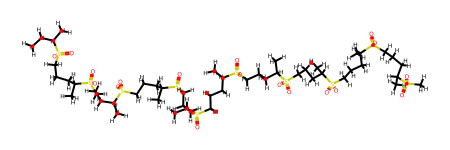

In [14]:
conformer

In [ ]:
conformer

{}

Mean corr magnitude: 0.18934648542554847


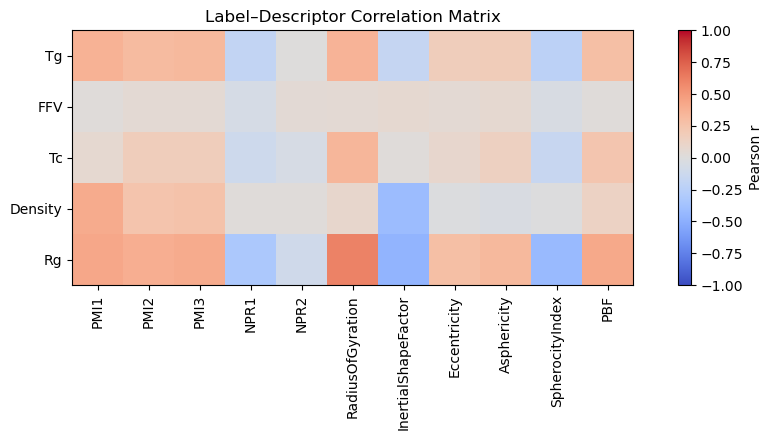

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
# Adjust if you saved the file elsewhere
# INPUT_CSV = "data/from_natsume/train_merged_with_3m_120t_descriptors.csv"
INPUT_CSV = "data/from_natsume/train_merged_with_v2_3d_descriptors.csv"
# INPUT_CSV = "data/from_host/train_with_v2_3d_descriptors.csv"

# Descriptor and label columns to include
DESCRIPTOR_COLS = [
    "PMI1", "PMI2", "PMI3", "NPR1", "NPR2",
    "RadiusOfGyration", "InertialShapeFactor",
    "Eccentricity", "Asphericity", "SpherocityIndex", "PBF",
]
LABEL_COLS = ["Tg", "FFV", "Tc", "Density", "Rg"]
# ------------------------------------------------------------------------

# Load data
df = pd.read_csv(INPUT_CSV)#.sample(n=128)
# print(len(df))

# Compute Pearson correlations
full_corr = df[DESCRIPTOR_COLS + LABEL_COLS].corr(method="pearson")

# Keep only label (rows) × descriptor (cols) block
corr_matrix = full_corr.loc[LABEL_COLS, DESCRIPTOR_COLS]

print('Mean corr magnitude:', corr_matrix.abs().mean().mean())

# --- visualise -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 3 + 0.3 * len(LABEL_COLS)))
im = ax.imshow(corr_matrix, vmin=-1, vmax=1, cmap="coolwarm")

# Tick labels
ax.set_xticks(range(len(DESCRIPTOR_COLS)))
ax.set_xticklabels(DESCRIPTOR_COLS, rotation=90)
ax.set_yticks(range(len(LABEL_COLS)))
ax.set_yticklabels(LABEL_COLS)

# Add colour bar
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Pearson r")
plt.title("Label–Descriptor Correlation Matrix")
plt.tight_layout()

In [64]:
from scipy.stats import pearsonr

filtered_df = df.dropna(subset=['RadiusOfGyration', 'Rg'])
print(len(filtered_df), len(df.dropna(subset=['Rg'])))
pearsonr(filtered_df['RadiusOfGyration'], filtered_df['Rg'])

# filtered_df = df.dropna(subset=['PMI1', 'Tg'])
# print(len(filtered_df), len(df.dropna(subset=['Tg'])))
# pearsonr(filtered_df['PMI1'], filtered_df['Tg'])

612 614


PearsonRResult(statistic=np.float64(0.606227105024413), pvalue=np.float64(1.1126113048558278e-62))

In [30]:
corr_values

,PMI1,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex,PBF
Tg,0.996256,0.73117,0.696947,-0.391657,-0.39955,0.392515,-0.981762,0.446934,0.287111,-0.053526,0.158709
FFV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
